In [1]:
import subprocess
import requests
import lkh
import pandas as pd
import numpy as np
import math
import random
from mypulp import Model, quicksum, GRB
import networkx as nx
import matplotlib.pyplot as plt
import sys
sys.path.append("../script")
import script.graphtools as gts

Optimal value =  3.499250528505675
Optimal tour =  [0, 8, 9, 3, 4, 6, 1, 2, 7, 5, 0]


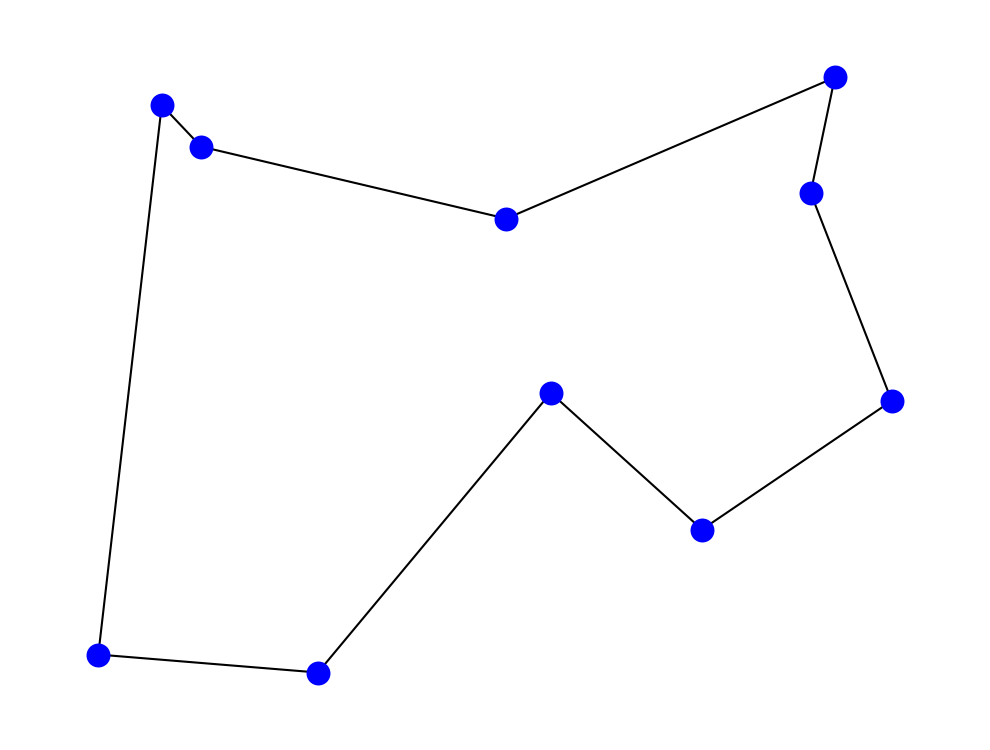

In [2]:
def distance(x1, y1, x2, y2):
    """2点間の直線距離を算出する関数

    :param x1:点1のx座標
    :param y1:点1のy座標
    :param x2:点2のx座標
    :param y2:点2のy座標
    :return: 2点間の直線距離
    """
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)


def make_data(n, start_index=0):
    """頂点数を元にコスト含めたデータを作成する
    :param n:頂点数
    :param start_index:
    :return:
    """
    if start_index == 0:
        V = range(n)
    elif start_index ==1:
        V = range(1, n-1)

    x = dict([(i, random.random()) for i in V])
    y = dict([(i, random.random()) for i in V])
    c = dict()

    for i in V:
        for j in V:
            c[i, j] = distance(x[i], y[i], x[j], y[j])

    return list(V), c, x, y


def tspdp(n, c, V):
    """

    :param n: 点数
    :param c: 移動コストを表す辞書
    :param V: 解きたい点集合を表すリスト
    :return:
    """
    def f(j, S):
        FS = frozenset(S) # https://flytech.work/blog/21215/
        if (j, FS) in memo:
            return memo[j, FS]
        elif FS == frozenset({j}):
            memo[j, FS] = c[V[0], j], V[0]
            return c[V[0], j], V[0]
        else:
            S0 = S.copy()
            min_value= 999999999
            S0.remove(j)
            for i in S0:
                if f(i, S0)[0] + c[i, j] < min_value:
                    min_value = f(i, S0)[0] + c[i, j]
                    prev = i
            memo[j, FS] = min_value, prev
            return memo[j, FS]

    memo = {}
    n = len(V)
    opt_val, prev = f(V[0], set(V))

    # restore tour
    j = V[0]
    S = set(V)
    tour = [j]
    while True:
        val, prev = memo[j, frozenset(S)]
        tour.append(prev)
        S = S - set({j})
        j = prev
        if j == V[0]:
            break

    tour.reverse()
    return opt_val, tour

n = 10
random.seed(1)
V, c, x, y = make_data(n)

opt_val, tour = tspdp(n, c, V)
print("Optimal value = ", opt_val)
print("Optimal tour = ", tour)

G = nx.Graph()
for idx, i in enumerate(tour[:-1]):
    G.add_edge(i, tour[idx+1])
pos = {i: (x[i], y[i]) for i in range(n)}
nx.draw(G, pos=pos, node_size=1000 / n +10, with_labels=False, node_color="blue")

In [3]:
## どれくらいの計算コストがかかるのか？
import time
costs = []
for n in range(5, 22):
    start_time = time.time()
    print(n)
    V, c, x, y = make_data(n)
    opt_val, tour = tspdp(n, c, V)
    end_time = time.time()
    t = end_time - start_time
    costs.append(t)
    print("Optimal value = ", opt_val)
    print("Optimal tour = ", tour)
    print("Culc Time = ", t)
    print("*"*20)

5
Optimal value =  2.0683087607530597
Optimal tour =  [0, 4, 3, 2, 1, 0]
Culc Time =  0.00017690658569335938
********************
6
Optimal value =  1.9701098149275538
Optimal tour =  [0, 4, 5, 2, 1, 3, 0]
Culc Time =  0.00031065940856933594
********************
7
Optimal value =  2.1973129413050905
Optimal tour =  [0, 3, 4, 6, 2, 5, 1, 0]
Culc Time =  0.0008378028869628906
********************
8
Optimal value =  2.4653599432231057
Optimal tour =  [0, 4, 3, 6, 2, 7, 5, 1, 0]
Culc Time =  0.0023283958435058594
********************
9
Optimal value =  2.643066284158076
Optimal tour =  [0, 5, 6, 3, 2, 7, 8, 1, 4, 0]
Culc Time =  0.0049419403076171875
********************
10
Optimal value =  2.819815815064612
Optimal tour =  [0, 6, 4, 2, 5, 8, 9, 1, 7, 3, 0]
Culc Time =  0.010945320129394531
********************
11
Optimal value =  2.615738798171157
Optimal tour =  [0, 5, 1, 2, 4, 3, 10, 7, 6, 9, 8, 0]
Culc Time =  0.024451732635498047
********************
12
Optimal value =  2.685165956306

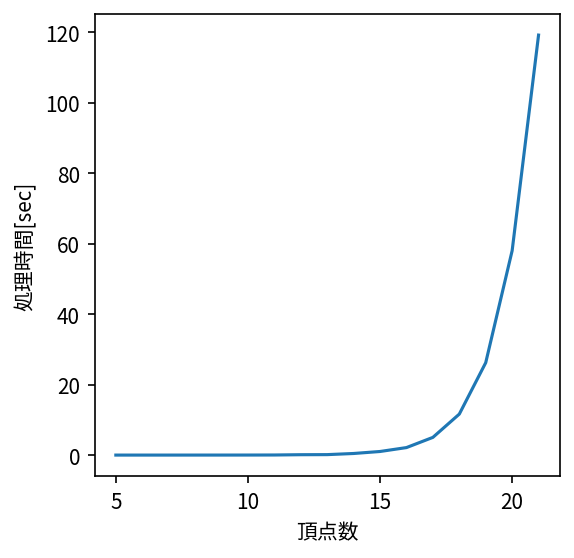

In [6]:
plt.figure(figsize=(4,4))
plt.plot(range(5, 22), costs)
plt.xlabel("頂点数")
plt.ylabel("処理時間[sec]")
plt.show()

In [20]:
# 部分巡回除去制約
# mypulpでは解けない
def tsp(V, c):
    """tsp -- model for solving the traveling salesman problem with callbacks
       - start with assignment model
       - add cuts until there are no sub-cycles
    Parameters:
        - V: set/list of nodes in the graph
        - c[i,j]: cost for traversing edge (i,j)
    Returns the optimum objective value and the list of edges used.
    """

    EPS = 1.0e-6

    def tsp_callback(model, where):
        if where != GRB.Callback.MIPSOL:
            return

        edges = []
        for (i, j) in x:
            if model.cbGetSolution(x[i, j]) > EPS:
                edges.append((i, j))

        G = nx.Graph()
        G.add_edges_from(edges)
        Components = list(nx.connected_components(G))

        if len(Components) == 1:
            return

        for S in Components:
            model.cbLazy(quicksum(x[i, j] for i in S for j in S if j > i) <= len(S) - 1)
            print ("cut: (%s) <= %s" % (S,len(S)-1) )
        return

    model = Model("tsp")
    # model.Params.OutputFlag = 0 # silent/verbose mode
    x = {}
    for i in V:
        for j in V:
            if j > i:
                x[i, j] = model.addVar(vtype="B", name="x(%s,%s)" % (i, j))
    model.update()

    for i in V:
        model.addConstr(
            quicksum(x[j, i] for j in V if j < i)
            + quicksum(x[i, j] for j in V if j > i)
            == 2,
            "Degree(%s)" % i,
        )

    model.setObjective(
        quicksum(c[i, j] * x[i, j] for i in V for j in V if j > i), GRB.MINIMIZE
    )

    model.update()
    model.__data = x
    return model, tsp_callback


def solve_tsp(V, c):
    model, tsp_callback = tsp(V, c)
    model.Params.DualReductions = 0
    model.Params.LazyConstraints = 1
    model.optimize(tsp_callback)
    x = model.__data

    EPS = 1.0e-6
    edges = []
    for (i, j) in x:
        if x[i, j].X > EPS:
            edges.append((i, j))
    return model.ObjVal, edges

# obj, edges = solve_tsp(V, c)
# print("Optimal tour:", edges)
# print("Optimal cost:", obj)

部分巡回路除去制約の実装は見当たらないので、ポテンシャル制約で解いてみる

https://www.kaggle.com/code/itoeiji/solving-tsp-and-vrp-by-mip-using-pulp/notebook

In [21]:
!pip install pulp

In [37]:
# データを設定（ここはdf）
# 変数の宣言
from scipy.spatial import distance_matrix

N = 10
np.random.seed(42)

df = pd.DataFrame({
    "x": np.random.randint(0, 100, N),
    "y": np.random.randint(0, 100, N)
})

df.loc[0, "x"] = 0
df.loc[0, "y"] = 0

df

,x,y
0,0,0
1,92,99
2,14,23
3,71,2
4,60,21
5,20,52
6,82,1
7,86,87
8,74,29
9,74,37


In [39]:
distance = pd.DataFrame(distance_matrix(df[["x", "y"]].values, df[["x", "y"]].values), index=df.index, columns=df.index).values
distance

array([[  0.        , 135.14806695,  26.92582404,  71.02816343,
         63.5688603 ,  55.71355311,  82.00609733, 122.33151679,
         79.47955712,  82.73451517],
       [135.14806695,   0.        , 108.90362712,  99.24716621,
         84.30895563,  85.98255637,  98.50888285,  13.41640786,
         72.277244  ,  64.56004957],
       [ 26.92582404, 108.90362712,   0.        ,  60.74537019,
         46.04345773,  29.61418579,  71.47027354,  96.33275663,
         60.29925373,  61.6116872 ],
       [ 71.02816343,  99.24716621,  60.74537019,   0.        ,
         21.9544984 ,  71.42128534,  11.04536102,  86.31338251,
         27.16615541,  35.12833614],
       [ 63.5688603 ,  84.30895563,  46.04345773,  21.9544984 ,
          0.        ,  50.60632372,  29.73213749,  70.9365914 ,
         16.1245155 ,  21.26029163],
       [ 55.71355311,  85.98255637,  29.61418579,  71.42128534,
         50.60632372,   0.        ,  80.28075735,  74.70609078,
         58.69412236,  56.04462508],
       [ 8

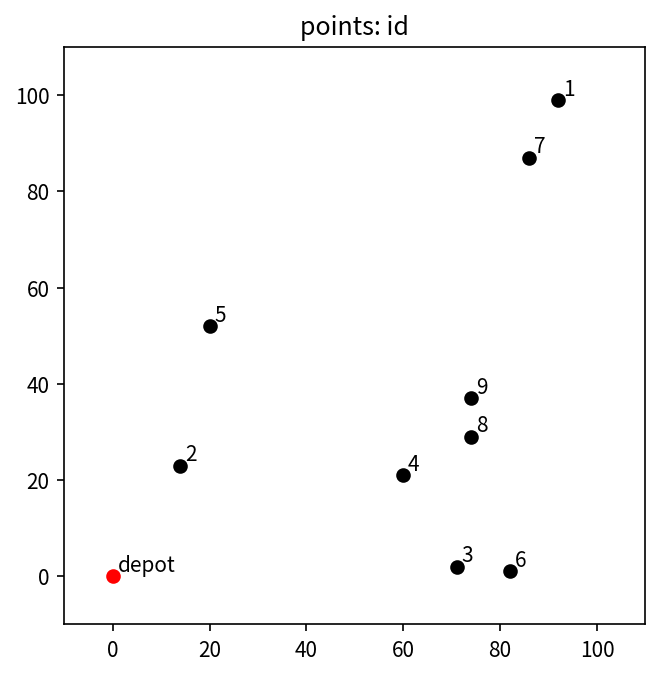

In [40]:
plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')

plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id')
plt.show()

In [41]:
import pulp as pp

model = pp.LpProblem("tsp_mip", pp.LpMinimize)

# set valiables
x = pp.LpVariable.dicts('x', ((i, j) for i in range(N) for j in range(N)), lowBound=0, upBound=1, cat='Binary')
# we need to keep track of the order in the tour to eliminate the possibility of subtours
u = pp.LpVariable.dicts('u', (i for i in range(N)), lowBound=1, upBound=N, cat='Integer')

objective = pp.lpSum(distance[i][j] * x[i,j] for i in range(N) for j in range(N) if i != j)
model += objective

# 対角行列を0にする
for i in range(N):
    model += x[i, i] == 0

for i in range(N):
    model += pp.lpSum(x[i,j] for j in range(N) if i != j) == 1
    model += pp.lpSum(x[j, i] for j in range(N) if i != j) == 1

# BigMをN（点数）で置き換えている気がする
for i in range(N):
    for j in range(N):
        if i != j and (i != 0 and j != 0):
            model += u[i] - u[j] <= N * (1 - x[i,j]) -1

status = model.solve()

print("Status: {}".format(pp.LpStatus[status]))
print("Optimal Value [a.u.]: {}".format(objective.value()))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/penguin/.conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8fbfa3606bfb438bba7f9364a37f3a5c-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/8fbfa3606bfb438bba7f9364a37f3a5c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 107 COLUMNS
At line 822 RHS
At line 925 BOUNDS
At line 1044 ENDATA
Problem MODEL has 102 rows, 109 columns and 406 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 226.457 - 0.00 seconds
Cgl0002I 10 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixe

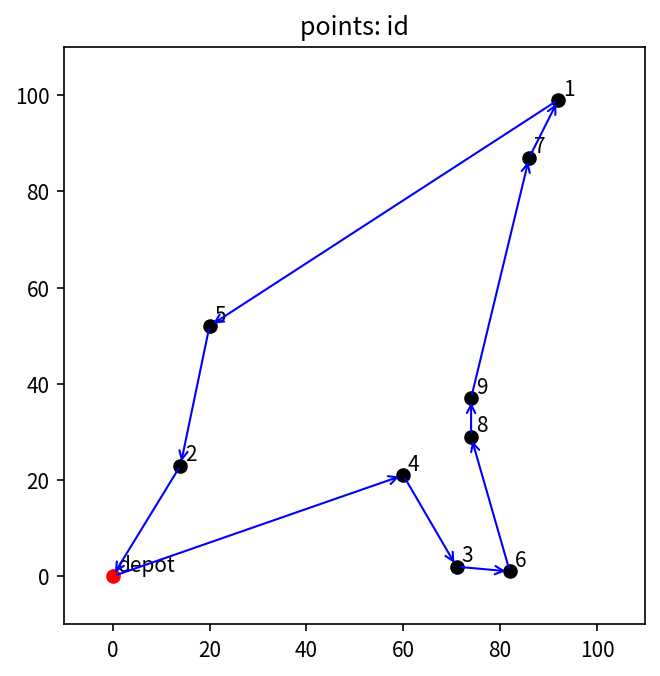

In [42]:
# check TSP problem and optimized route

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')

    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')

plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id')

# draw optimal route
routes = [(i, j) for i in range(N) for j in range(N) if pp.value(x[i, j]) == 1]
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in routes:
    plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)

plt.show()